In [1]:
MAKE_BOOK_FIGURES=True

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

def set_book_style():
    plt.style.use('seaborn-v0_8-white') 
    sns.set_style("ticks")
    sns.set_palette("deep")

    mpl.rcParams.update({
        # Font settings
        'font.family': 'serif',  # For academic publishing
        'font.size': 8,  # As requested, 10pt font
        'axes.labelsize': 8,
        'axes.titlesize': 8,
        'xtick.labelsize': 7,  # Slightly smaller for better readability
        'ytick.labelsize': 7,
        'legend.fontsize': 7,
        
        # Line and marker settings for consistency
        'axes.linewidth': 0.5,
        'grid.linewidth': 0.5,
        'lines.linewidth': 1.0,
        'lines.markersize': 4,
        
        # Layout to prevent clipped labels
        'figure.constrained_layout.use': True,
        
        # Default DPI (will override when saving)
        'figure.dpi': 600,
        'savefig.dpi': 600,
        
        # Despine - remove top and right spines
        'axes.spines.top': False,
        'axes.spines.right': False,
        
        # Remove legend frame
        'legend.frameon': False,
        
        # Additional trim settings
        'figure.autolayout': True,  # Alternative to constrained_layout
        'savefig.bbox': 'tight',    # Trim when saving
        'savefig.pad_inches': 0.1   # Small padding to ensure nothing gets cut off
    })

def set_notebook_style():
    plt.style.use('seaborn-v0_8-white')
    sns.set_style("ticks")
    sns.set_palette("deep")

    mpl.rcParams.update({
        # Font settings - using default sizes
        'font.family': 'serif',
        'axes.labelsize': 10,
        'axes.titlesize': 10,
        'xtick.labelsize': 9,
        'ytick.labelsize': 9,
        'legend.fontsize': 9,
        
        # Line and marker settings
        'axes.linewidth': 0.5,
        'grid.linewidth': 0.5,
        'lines.linewidth': 1.0,
        'lines.markersize': 4,
        
        # Layout settings
        'figure.constrained_layout.use': True,
        
        # Remove only top and right spines
        'axes.spines.top': False,
        'axes.spines.right': False,
        
        # Remove legend frame
        'legend.frameon': False,
        
        # Additional settings
        'figure.autolayout': True,
        'savefig.bbox': 'tight',
        'savefig.pad_inches': 0.1
    })

def save_for_book(fig, filename, is_vector=True, **kwargs):
    """
    Save a figure with book-optimized settings.
    
    Parameters:
    -----------
    fig : matplotlib figure
        The figure to save
    filename : str
        Filename without extension
    is_vector : bool
        If True, saves as vector at 1000 dpi. If False, saves as raster at 600 dpi.
    **kwargs : dict
        Additional kwargs to pass to savefig
    """    
    # Set appropriate DPI and format based on figure type
    if is_vector:
        dpi = 1000
        ext = '.pdf'
    else:
        dpi = 600
        ext = '.tif'
    
    # Save the figure with book settings
    fig.savefig(f"{filename}{ext}", dpi=dpi, **kwargs)

def make_full_width_fig():
    return plt.subplots(figsize=(4.7, 2.9), constrained_layout=True)

def make_half_width_fig():
    return plt.subplots(figsize=(2.35, 1.45), constrained_layout=True)

if MAKE_BOOK_FIGURES:
    set_book_style()
else:
    set_notebook_style()

make_full_width_fig = make_full_width_fig if MAKE_BOOK_FIGURES else lambda: plt.subplots()
make_half_width_fig = make_half_width_fig if MAKE_BOOK_FIGURES else lambda: plt.subplots()

(automatic_relevance_determination)=
# Automatic Relevance Determination

## Example (Quadratic)

As before, let's start with our familiar synthetic example:

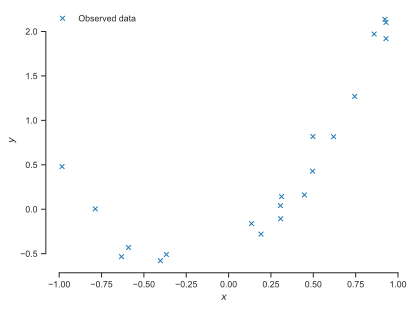

In [2]:
np.random.seed(12345)

num_obs = 20
x = -1.0 + 2 * np.random.rand(num_obs)
w0_true = -0.5
w1_true = 1.0
w2_true = 2.0
sigma_true = 0.1
y = (
    w0_true
    + w1_true * x
    + w2_true * x ** 2
    + sigma_true * np.random.randn(num_obs)
)

fig, ax = plt.subplots()
ax.plot(x, y, 'x', label='Observed data')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
plt.legend(loc='best', frameon=False)
sns.despine(trim=True);

Let's also copy-paste the code we have developped so far:

In [3]:
def get_polynomial_design_matrix(x, degree):
    """Return the polynomial design matrix of ``degree`` evaluated at ``x``.
    
    Arguments:
    x      -- A 2D array with only one column.
    degree -- An integer greater than zero.
    """
    assert isinstance(x, np.ndarray), 'x is not a numpy array.'
    assert x.ndim == 2, 'You must make x a 2D array.'
    assert x.shape[1] == 1, 'x must be a column.'
    cols = []
    for i in range(degree+1):
        cols.append(x ** i)
    return np.hstack(cols)

def get_fourier_design_matrix(x, L, num_terms):
    """Fourier expansion with ``num_terms`` cosines and sines.
    
    Arguments:
    x          --  A 2D array with only one column.
    L          --  The "length" of the domain.
    num_terms  --  How many Fourier terms do you want.
                   This is not the number of basis
                   functions you get. The number of basis functions
                   is 1 + num_terms / 2. The first one is a constant.
    """
    assert isinstance(x, np.ndarray), 'x is not a numpy array.'
    assert x.ndim == 2, 'You must make x a 2D array.'
    assert x.shape[1] == 1, 'x must be a column.'
    N = x.shape[0]
    cols = [np.ones((N, 1))]
    for i in range(int(num_terms / 2)):
        cols.append(np.cos(2 * (i+1) * np.pi / L * x))
        cols.append(np.sin(2 * (i+1) * np.pi / L * x))
    return np.hstack(cols)
                    
def get_rbf_design_matrix(x, x_centers, ell):
    """Radial basis functions design matrix.
    
    Arguments:
    x        --  The input points on which you want to evaluate the
                 design matrix.
    x_center --  The centers of the radial basis functions.
    ell      --  The lengthscale of the radial basis function.
    """
    assert isinstance(x, np.ndarray), 'x is not a numpy array.'
    assert x.ndim == 2, 'You must make x a 2D array.'
    assert x.shape[1] == 1, 'x must be a column.'
    N = x.shape[0]
    cols = [np.ones((N, 1))]
    for i in range(x_centers.shape[0]):
        cols.append(np.exp(-(x - x_centers[i]) ** 2 / ell))
    return np.hstack(cols)

def plot_posterior_predictive(
    model,
    xx,
    phi_func,
    phi_func_args=(),
    y_true=None
):
    """Plot the posterior predictive separating
    aleatory and espitemic uncertainty.
    
    Arguments:
    model    -- A trained model.
    xx       -- The points on which to evaluate
                the posterior predictive.
    phi_func -- The function to use to compute
                the design matrix.
    
    Keyword Arguments:
    phi_func_args -- Any arguments passed to the
                     function that calculates the
                     design matrix.
    y_true        -- The true response for plotting.
    """
    Phi_xx = phi_func(
        xx[:, None],
        *phi_func_args
    )
    yy_mean, yy_measured_std = model.predict(
        Phi_xx,
        return_std=True
    )
    sigma = np.sqrt(1.0 / model.alpha_)
    yy_std = np.sqrt(yy_measured_std ** 2 - sigma**2)
    yy_le = yy_mean - 2.0 * yy_std
    yy_ue = yy_mean + 2.0 * yy_std
    yy_lae = yy_mean - 2.0 * yy_measured_std
    yy_uae = yy_mean + 2.0 * yy_measured_std

    fig, ax = plt.subplots()
    ax.plot(xx, yy_mean, 'r', label="Posterior mean")
    ax.fill_between(
        xx,
        yy_le,
        yy_ue,
        color='red',
        alpha=0.25,
        label="95% epistemic credible interval"
    )
    ax.fill_between(
        xx,
        yy_lae,
        yy_le,
        color='green',
        alpha=0.25
    )
    ax.fill_between(
        xx,
        yy_ue,
        yy_uae,
        color='green',
        alpha=0.25,
        label="95% epistemic + aleatory credible interval"
    )
    ax.plot(x, y, 'kx', label='Observed data')
    if y_true is not None:
        ax.plot(xx, y_true, "--", label="True response")
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    plt.legend(loc="best", frameon=False)
    sns.despine(trim=True)
    
def plot_posterior_samples(
    model,
    xx,
    phi_func,
    phi_func_args=(),
    num_samples=10,
    y_true=None,
    nugget=1e-6 
):
    """Plot posterior samples from the model.
    
    Arguments:
    model    -- A trained model.
    xx       -- The points on which to evaluate
                the posterior predictive.
    phi_func -- The function to use to compute
                the design matrix.
    
    Keyword Arguments:
    phi_func_args -- Any arguments passed to the
                     function that calculates the
                     design matrix.
    num_samples   -- The number of samples to take.
    y_true        -- The true response for plotting.
    nugget        -- A small number to add the covariance
                     if it is not positive definite
                     (numerically).
    """
    Phi_xx = phi_func(
        xx[:, None],
        *phi_func_args
    )
    m = model.coef_
    S = model.sigma_
    w_post = st.multivariate_normal(
        mean=m,
        cov=S + nugget * np.eye(S.shape[0])
    )
    fig, ax = plt.subplots()
    for _ in range(num_samples):
        w_sample = w_post.rvs()
        yy_sample = Phi_xx @ w_sample
        ax.plot(xx, yy_sample, 'r', lw=0.5)
    ax.plot([], [], "r", lw=0.5, label="Posterior samples")
    ax.plot(x, y, 'kx', label='Observed data')
    ax.plot(xx, yy_true, label='True response surface')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    plt.legend(loc="best", frameon=False)
    sns.despine(trim=True)

We are not going to implement the automatic relevance determination from scratch. Instead we are going to use the implementation in [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ARDRegression.html#sklearn.linear_model.ARDRegression).
Here is how you do it:

In [4]:
from sklearn.linear_model import ARDRegression

# Parameters
degree = 6

# Design matrix
Phi = get_polynomial_design_matrix(x[:, None], degree)

print(Phi.shape)

# Fit
model = ARDRegression(
    fit_intercept=False
).fit(Phi, y)

(20, 7)


Here is how you can get the noise variance $\sigma^2$:

In [5]:
sigma = np.sqrt(1.0 / model.alpha_)
print('sigma = {0:1.2f}'.format(sigma))

sigma = 0.14


Here is how you can get the precision corresponding to each weight.
Remember, that very high precision means that the corresponding basis function can be safely removed from your model.

Prior w precision: [4.66313836e+00 1.01598665e+00 2.78049960e-01 3.23046841e+03
 2.26488490e+02 3.30034536e+03 1.41262482e+03]


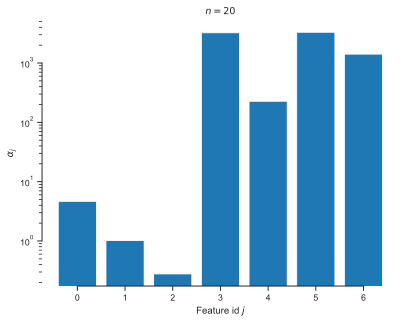

In [6]:
alpha = model.lambda_
print(f"Prior w precision: {alpha}")

fig, ax = plt.subplots()
ax.bar(np.arange(degree+1), alpha)
ax.set_xlabel('Feature id $j$')
ax.set_ylabel(r'$\alpha_j$')
ax.set_yscale("log")
ax.set_title(f'$n={num_obs}$')
sns.despine(trim=True);

Remember that the higher the prior precision $\alpha_j$ of a weight, the more its prior (and consequently the posterior) concentrates about zero.
The corresponding weight is essentially zero for extremely high values of prior precision.
ARD tells us that we don't have to include the 3rd, 4th, 5th, and 6th-degree monomials.

Now, let's get the posterior mean of the weights.
Notice that the weights corresponding to 3rd, 4th, 5th, and 6th degree polynomials are very close to zero:

In [7]:
# The posterior mean of the weights is here (this is for the normalized features, however)
m = model.coef_
print(f"Posterior mean w: {m}")

Posterior mean w: [-4.60269190e-01  9.90602538e-01  1.89292198e+00 -7.90739804e-04
  9.78004546e-03 -1.19461914e-03  1.78645558e-03]


And here is the posterior covariance of the weights:

In [8]:
S = model.sigma_
print("Posterior covariance w:")
print(S)

Posterior covariance w:
[[ 2.64509604e-03 -2.65565824e-04 -4.50740411e-03  2.80642987e-05
   5.30131358e-04  2.34687666e-05  9.39888680e-05]
 [-2.65565824e-04  2.97382970e-03 -7.20531667e-04 -1.93011234e-04
  -1.08538654e-05 -1.42264395e-04  4.50997575e-06]
 [-4.50740411e-03 -7.20531667e-04  1.46909117e-02 -5.81874499e-05
  -4.07996562e-03 -4.80189807e-05 -5.66289686e-04]
 [ 2.80642987e-05 -1.93011234e-04 -5.81874499e-05  3.06928254e-04
   2.89225535e-06 -2.94801270e-06  8.68695203e-07]
 [ 5.30131358e-04 -1.08538654e-05 -4.07996562e-03  2.89225535e-06
   4.31350654e-03  3.21736555e-06 -2.25857568e-05]
 [ 2.34687666e-05 -1.42264395e-04 -4.80189807e-05 -2.94801270e-06
   3.21736555e-06  2.99572682e-04  1.00328797e-06]
 [ 9.39888680e-05  4.50997575e-06 -5.66289686e-04  8.68695203e-07
  -2.25857568e-05  1.00328797e-06  7.02715011e-04]]


Now, let's plot the marginal posterior for each weight.

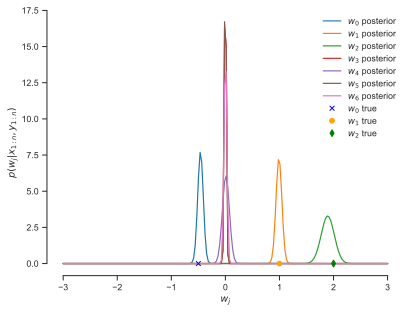

In [9]:
import scipy.stats as st

ww = np.linspace(-3.0, 3.0, 200)

fig, ax = plt.subplots()
for j in range(S.shape[0]):
    wj_post = st.norm(
        loc=m[j],
        scale=np.sqrt(S[j, j])
    )
    ax.plot(
        ww,
        wj_post.pdf(ww),
        label=f'$w_{{{j}}}$ posterior')
ax.plot([w0_true], [0], 'bx', label="$w_0$ true")
ax.plot([w1_true], [0], 'o', color="orange", label="$w_1$ true")
ax.plot([w2_true], [0], 'd', color="green", label="$w_2$ true")
ax.set_xlabel("$w_j$")
ax.set_ylabel("$p(w_j|x_{{1:n}}, y_{{1:n}})$")
plt.legend(loc='best', frameon=False)
sns.despine(trim=True);

Notice how the 3rd, 4th, 5th, and 6th are centered at zero.
Also, notice how the actual weights have been correctly identified.

Let's now plot the posterior predictive separating aleatory and epistemic uncertainty:

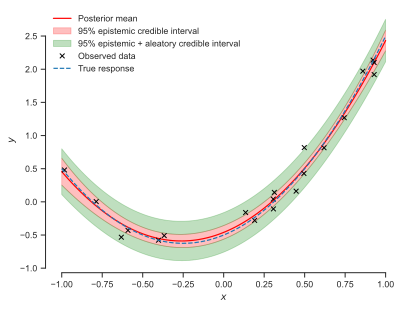

In [10]:
xx = np.linspace(-1, 1, 100)
yy_true = w0_true + w1_true * xx + w2_true * xx ** 2

plot_posterior_predictive(
    model,
    xx,
    get_polynomial_design_matrix,
    phi_func_args=(degree,),
    y_true=yy_true
)

Let's take samples from the posterior:

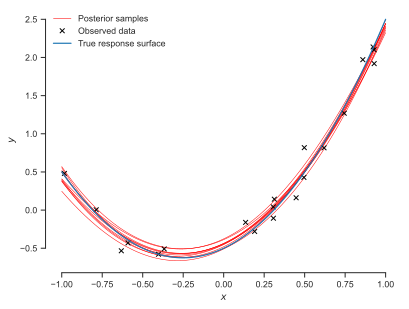

In [11]:
plot_posterior_samples(
    model,
    xx,
    get_polynomial_design_matrix,
    phi_func_args=(degree,),
    y_true=yy_true
)

### Questions
+ Rerun with a smaller number of observations, say $n=5$. What happens to the epistemic uncertainty?
+ Rerun with a minimal number of observations, say $n=2$. What happens then? (The step that samples from the posterior may not work as expected. Please look at the comment in the code to fix the problem.)
+ Rerun everything with a higher degree polynomial. Try $4$, $8$, and $16$.
Notice that the fit remains good in between, but how you extrapolate changes. Why?